<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-deepar"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [ ]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

# Install pip packages

In [ ]:
!pip install mxnet
!pip install gluonts

# Select Task

In [2]:
task = 15

In [3]:
import pandas as pd

# only use surface solar radiation (169), surface thermal radiation (175) and top net solar radiation (178)
predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR169', 'VAR175', 'VAR178']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task+1}/train{task+1}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

In [4]:
solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)
train_data

,ZONEID 1,ZONEID 2,ZONEID 3
TIMESTAMP,,,
2012-04-01 01:00:00,0.754103,0.647328,0.799000
2012-04-01 02:00:00,0.555000,0.621822,0.817500
2012-04-01 03:00:00,0.438397,0.472692,0.571500
2012-04-01 04:00:00,0.145449,0.098866,0.063775
2012-04-01 05:00:00,0.111987,0.104393,0.103700
...,...,...,...
2014-06-30 20:00:00,0.000000,0.000000,0.000000
2014-06-30 21:00:00,0.000064,0.000040,0.000025
2014-06-30 22:00:00,0.013846,0.015142,0.084900


In [5]:
predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178']]
                             .rename({'VAR169': f'SURFACE SOLAR RADIATION {i}',
                                      'VAR175': f'SURFACE THERMAL RADIATION {i}',
                                      'VAR178': f'TOP NET SOLAR RADIATION {i}'}, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)

In [6]:
for i in range(1, 4):
    predictor_data[f'SURFACE SOLAR RADIATION {i}'] /= predictor_data[f'SURFACE SOLAR RADIATION {i}'].max()
    predictor_data[f'SURFACE THERMAL RADIATION {i}'] /= predictor_data[f'SURFACE THERMAL RADIATION {i}'].max()
    predictor_data[f'TOP NET SOLAR RADIATION {i}'] /= predictor_data[f'TOP NET SOLAR RADIATION {i}'].max()
predictor_data

,SURFACE SOLAR RADIATION 1,SURFACE THERMAL RADIATION 1,TOP NET SOLAR RADIATION 1,SURFACE SOLAR RADIATION 2,SURFACE THERMAL RADIATION 2,TOP NET SOLAR RADIATION 2,SURFACE SOLAR RADIATION 3,SURFACE THERMAL RADIATION 3,TOP NET SOLAR RADIATION 3
TIMESTAMP,,,,,,,,,
2012-04-01 01:00:00,0.075036,0.034681,0.076927,0.075329,0.034523,0.077026,0.075275,0.033892,0.076928
2012-04-01 02:00:00,0.155907,0.070565,0.159924,0.156009,0.070098,0.159798,0.154586,0.068502,0.158553
2012-04-01 03:00:00,0.230590,0.106171,0.240292,0.228093,0.105521,0.238421,0.222792,0.103328,0.233886
2012-04-01 04:00:00,0.287023,0.141938,0.304604,0.282115,0.141474,0.300619,0.277811,0.138698,0.296348
2012-04-01 05:00:00,0.324356,0.180378,0.352287,0.320843,0.179882,0.349239,0.319244,0.175985,0.346746
...,...,...,...,...,...,...,...,...,...
2014-06-30 20:00:00,0.241159,0.557521,0.254016,0.252700,0.559101,0.258763,0.255466,0.577358,0.256197
2014-06-30 21:00:00,0.241159,0.584266,0.254016,0.252700,0.585863,0.258763,0.255466,0.606223,0.256197
2014-06-30 22:00:00,0.243504,0.610605,0.257703,0.255101,0.611597,0.262428,0.257708,0.632148,0.259650


In [7]:
# define the parameters of the dataset
gefcom14_metadata = {'num_series': 3,
                     'num_steps': len(predictor_data),
                     'prediction_length': len(benchmark) // 3, # three different timezones
                     'freq': '1H',
                     'start': [pd.Timestamp(predictor_data.index[0], freq='1H') for _ in range(3)]
                     }

In [8]:
targets = [train_data[:-gefcom14_metadata['prediction_length']][f'ZONEID {i}'].values for i in [1,2,3]]
starts = gefcom14_metadata['start']
features = [predictor_data[:-gefcom14_metadata['prediction_length']][[f'SURFACE SOLAR RADIATION {i}', f'SURFACE THERMAL RADIATION {i}', f'TOP NET SOLAR RADIATION {i}']].values.T for i in [1,2,3]]

In [9]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([{
    FieldName.TARGET: target,
    FieldName.START: start,
    FieldName.FEAT_DYNAMIC_REAL: fdr,
    FieldName.FEAT_STATIC_CAT: [fsc]
  } for (target, start, fdr, fsc) in zip(targets, starts, features, [1,2,3])], 
  freq=gefcom14_metadata['freq'])

In [10]:
targets = [train_data[f'ZONEID {i}'].values for i in [1,2,3]]
starts = gefcom14_metadata['start']
features = [predictor_data[[f'SURFACE SOLAR RADIATION {i}', f'SURFACE THERMAL RADIATION {i}', f'TOP NET SOLAR RADIATION {i}']].values.T for i in [1,2,3]]

In [11]:
test_ds = ListDataset([{
    FieldName.TARGET: target,
    FieldName.START: start,
    FieldName.FEAT_DYNAMIC_REAL: fdr,
    FieldName.FEAT_STATIC_CAT: [fsc]
  } for (target, start, fdr, fsc) in zip(targets, starts, features, [1,2,3])], 
  freq=gefcom14_metadata['freq'])

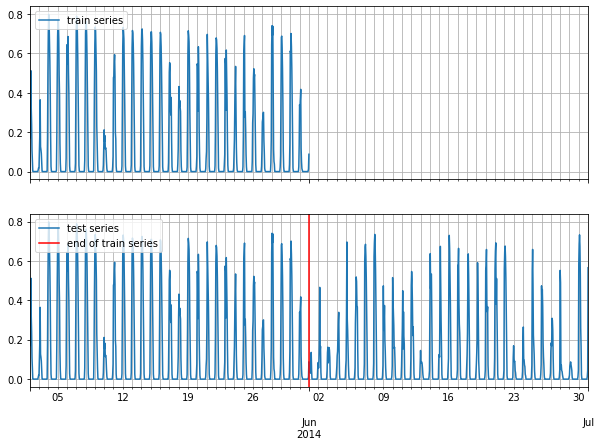

In [12]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

train_series = to_pandas(train_entry)
test_series = to_pandas(test_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series[-24*30:].plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series[-24*30-gefcom14_metadata['prediction_length']:].plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [ ]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.mx.distribution import PiecewiseLinearOutput

estimator = DeepAREstimator(freq=gefcom14_metadata['freq'],
                            prediction_length=gefcom14_metadata['prediction_length'],
                            distr_output=PiecewiseLinearOutput(num_pieces=3), # SQF-RNN
                            use_feat_dynamic_real=True,
                            trainer=Trainer(epochs=7))

ensemble_count = 7
predictors = []

for _ in range(ensemble_count):
    predictor = estimator.train(train_ds)
    predictors.append(predictor)

In [14]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm import tqdm

forecast_ensemble = []
tss_ensemble = []

for predictor in tqdm(predictors):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=500,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    forecast_ensemble.append(forecasts)
    tss_ensemble.append(tss)

100%|██████████| 7/7 [03:04<00:00, 26.41s/it]


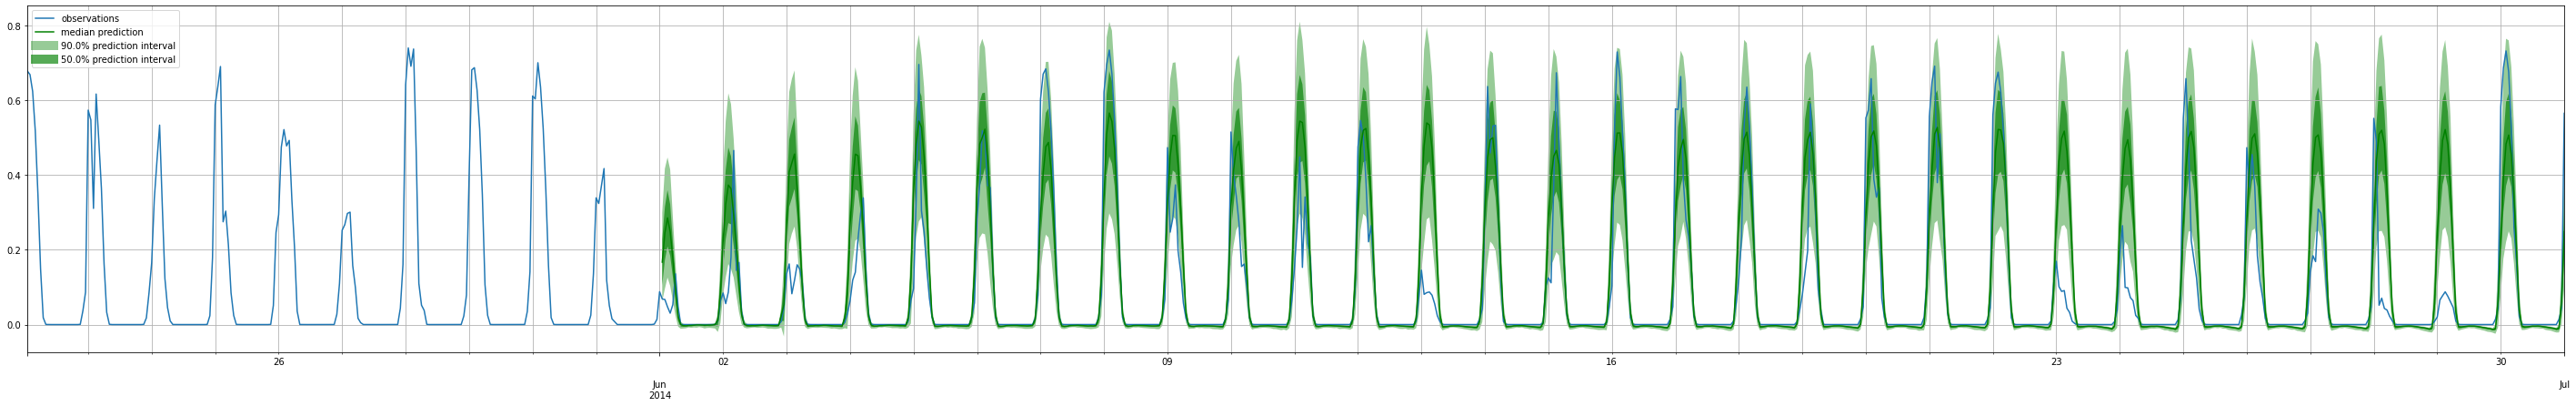

In [15]:
def plot_prob_forecasts(ts_entry, forecast_entry, output_file=None):
    plot_length = 24 * 40
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(50, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    if output_file is not None:
        plt.savefig(output_file)
    plt.show()

plot_prob_forecasts(tss[0], forecasts[0])

In [16]:
import numpy as np

prediction_ensemble = []

for forecasts in forecast_ensemble:
    zone_predictions = []
    for i, forecast in enumerate(forecasts):
        prediction = pd.concat([np.maximum(forecast.quantile_ts(p/100), 0)
                                for p in range(1, 100)], axis=1)\
            .rename(columns={p: str((p+1)/100) for p in range(99)})
        prediction.insert(0, 'ZONEID', i+1)
        prediction.index.name = 'TIMESTAMP'
        zone_predictions.append(prediction)

    predictions = pd.concat(zone_predictions)
    prediction_ensemble.append(predictions)

In [22]:
averaged_predictions = pd.DataFrame()

for p in range(1, 100):
    quantile_columns = [prediction[str(p/100)] for prediction in prediction_ensemble]
    averaged_predictions.insert(p-1, str(p/100), np.mean(quantile_columns, axis=0))

averaged_predictions.to_csv(f'results/prediction_sqf_rnn_task{task}.csv')

averaged_predictions

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,0.048222,0.050233,0.052616,0.054345,0.055893,0.058381,0.060168,0.062619,0.065156,0.067419,...,0.273122,0.276261,0.280650,0.285334,0.288955,0.292589,0.295817,0.299679,0.302708,0.306004
1,0.033207,0.040157,0.045862,0.051298,0.059162,0.063172,0.066758,0.070142,0.075655,0.079188,...,0.352426,0.357577,0.364556,0.374628,0.382248,0.390484,0.400621,0.414648,0.432189,0.456599
2,0.029122,0.035552,0.041507,0.047462,0.051813,0.058985,0.064567,0.067898,0.072567,0.076067,...,0.373449,0.380368,0.388286,0.395839,0.404220,0.413882,0.427719,0.442046,0.460823,0.486827
3,0.015696,0.018796,0.022183,0.026333,0.029739,0.034952,0.039496,0.042239,0.046104,0.049591,...,0.316491,0.324091,0.329413,0.336228,0.343138,0.351870,0.361876,0.379046,0.390051,0.418072
4,0.005528,0.008346,0.013039,0.015128,0.017477,0.019290,0.021776,0.024111,0.027815,0.029746,...,0.228724,0.232650,0.238304,0.244575,0.252505,0.259441,0.268529,0.279399,0.288536,0.307223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000046,0.000061,0.000091,0.000115,0.000139,...,0.003428,0.003691,0.003940,0.004346,0.004635,0.004943,0.005333,0.005841,0.006247,0.006835
2156,0.000000,0.000000,0.000000,0.000000,0.000050,0.000099,0.000119,0.000148,0.000184,0.000242,...,0.007344,0.007849,0.008286,0.008683,0.009196,0.009734,0.010463,0.011584,0.012994,0.015001
2157,0.002859,0.004169,0.005220,0.005633,0.006128,0.006551,0.007037,0.007358,0.007643,0.008060,...,0.074010,0.077213,0.080129,0.084510,0.088829,0.093918,0.099921,0.105581,0.114812,0.132055
2158,0.033463,0.041372,0.046164,0.049365,0.052433,0.055237,0.059990,0.062597,0.064760,0.067294,...,0.267738,0.273551,0.281859,0.288363,0.297020,0.305720,0.316632,0.334947,0.350710,0.373829


## Plotting the quantile prediction for the first entries

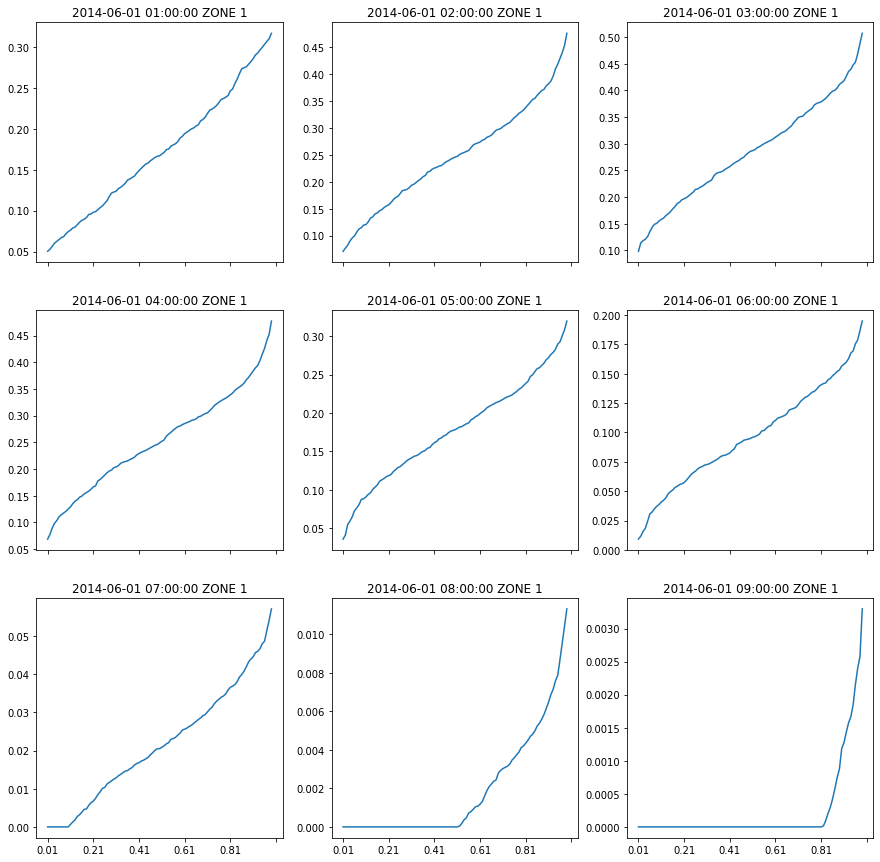

In [18]:
fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    predictions.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3], 
                                      title=str(predictions.index[i]) + ' ZONE ' 
                                      + str(int(predictions.iloc[i]['ZONEID'])))

# Evaluate Loss

The loss function is the pinnball loss: 
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [19]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction, 
                    (1 - percentiles / 100) * (prediction - actual), 
                    percentiles / 100 * (actual - prediction))
    return loss

loss1 = np.mean(pinnball_loss(tss[0].values[-gefcom14_metadata['prediction_length']:,0], predictions[predictions['ZONEID'] == 1].drop('ZONEID', axis=1)))
loss2 = np.mean(pinnball_loss(tss[1].values[-gefcom14_metadata['prediction_length']:,0], predictions[predictions['ZONEID'] == 2].drop('ZONEID', axis=1)))
loss3 = np.mean(pinnball_loss(tss[2].values[-gefcom14_metadata['prediction_length']:,0], predictions[predictions['ZONEID'] == 3].drop('ZONEID', axis=1)))

print(f"Loss of task {task}: {round((loss1 + loss2 + loss3) / 3, 5)}")

Loss of task 15: 0.01949


In [20]:
loss1 = np.mean(pinnball_loss(tss[0].values[-gefcom14_metadata['prediction_length']:,0], benchmark[benchmark['ZONEID'] == 1].drop('ZONEID', axis=1)))
loss2 = np.mean(pinnball_loss(tss[1].values[-gefcom14_metadata['prediction_length']:,0], benchmark[benchmark['ZONEID'] == 2].drop('ZONEID', axis=1)))
loss3 = np.mean(pinnball_loss(tss[2].values[-gefcom14_metadata['prediction_length']:,0], benchmark[benchmark['ZONEID'] == 3].drop('ZONEID', axis=1)))

print(f"Benchmark loss of task {task}: {round((loss1 + loss2 + loss3) / 3, 5)}")

Benchmark loss of task 15: 0.0285
